In [ ]:
# 1. Подберите параметры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

(np.float64(-0.5), np.float64(399.5), np.float64(299.5), np.float64(-0.5))

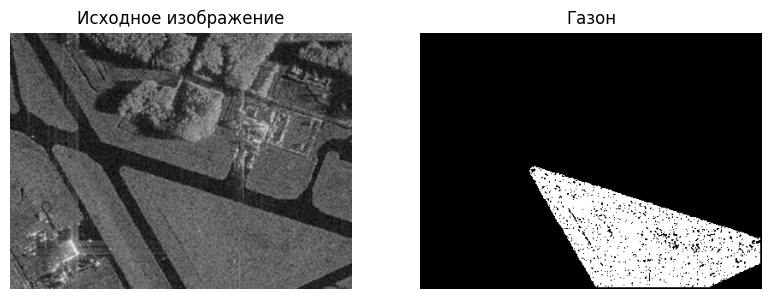

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters

# Подберите параметры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

# критерий однородности на основе среднего значения
def homo_average(img, mask, point, T): 
    # среднее значение в регионе:
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0]) 
    if abs(av_val - img[point]) <= T:
        return True
    return False

# критерий однородности на основе медианы
def homo_median(img, mask, point, T):
    if np.count_nonzero(mask) > 0:
        # вычисляем медиану значений в регионе:
        median_val = np.median(img[mask > 0])
        if abs(median_val - img[point]) <= T:
            return True
    return False

# алгоритм разрастания регионов
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i,j] == 0 and mask[i - r:i + r, j - r: j + r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

seed_point = (250, 250)  
mask_lawn_avg = region_growing(image_gray, seed_point, homo_average, 2, 15)  

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_lawn_avg, cmap="gray")
plt.title("Газон")
plt.axis('off')

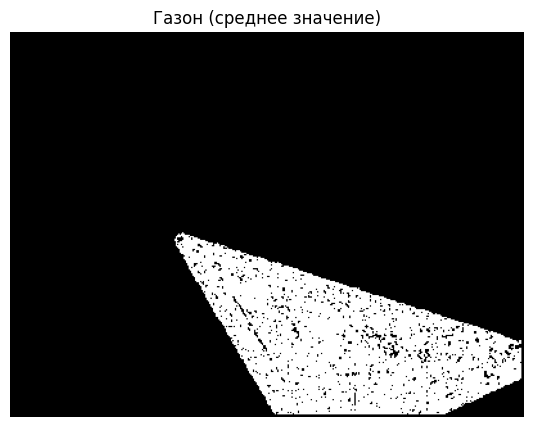

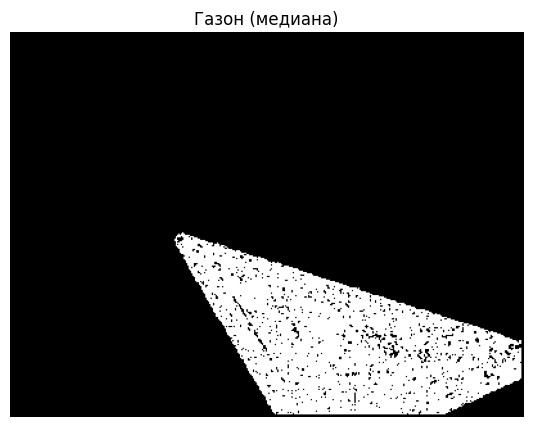

Сравнение критериев однородности:
Пикселей выделено средним: 19437
Пикселей выделено медианой: 19475


In [3]:
# Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

mask_lawn_median = region_growing(image_gray, seed_point, homo_median, 2, 15)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask_lawn_avg, cmap="gray")
plt.title("Газон (среднее значение)")
plt.axis('off')


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.imshow(mask_lawn_median, cmap="gray")
plt.title("Газон (медиана)")
plt.axis('off')
plt.show()

# Сравнение результатов
print("Сравнение критериев однородности:")
print(f"Пикселей выделено средним: {np.count_nonzero(mask_lawn_avg)}")
print(f"Пикселей выделено медианой: {np.count_nonzero(mask_lawn_median)}")

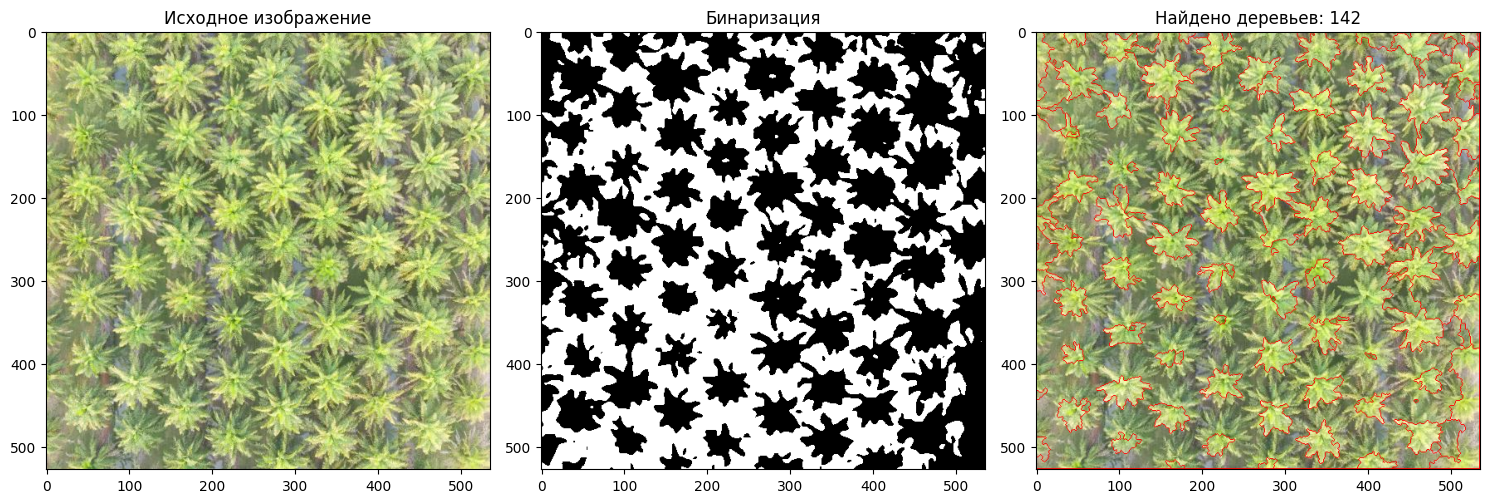

In [13]:
# Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

image = cv2.imread("palm_1.JPG")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))

blurred = cv2.GaussianBlur(image_gray, (13, 13), 0)
ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title('Исходное изображение')

plt.subplot(2, 3, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Бинаризация')

dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

local_maxima = ndimage.maximum_filter(dist_transform, size=20, mode='constant')

ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

ret, markers = cv2.connectedComponents(sure_fg)
markers[dist_transform == local_maxima] = 1

markers = ndimage.label(markers)[0]  
markers = cv2.watershed(image, markers.astype(np.int32))

num_trees = len(np.unique(markers)) - 1

segmented_image = image.copy()
segmented_image[markers == -1] = [0, 0, 255]  

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title(f'Найдено деревьев: {num_trees}')

plt.tight_layout()
plt.show()